In [8]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from sklearn.metrics import confusion_matrix
from multiprocessing import cpu_count

import config
from complete_training_data_processing import CompleteModelsDataProcessor
from model_inspection_funcs import neuron_data_from_image, propagate_neuron_data, sample_images

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
blue_yellow = ["#FFD700", "#0000FF"]
# blue_yellow.reverse()
sns.set_palette(blue_yellow)

device = torch.device("cpu")
dtype = torch.float32

num_passes = 4
pairs_num = 1000

In [9]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

In [10]:
# horrible data stuff
connections = (
    pd.read_csv(
        "adult_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)
# set weights to 1 because we are not training
connections["weight"] = 1
# reshuffle column post_rood_id of the dataframe connections
shuffled_connections = connections.copy()
shuffled_connections["post_root_id"] = np.random.permutation(
    connections["post_root_id"]
)
right_root_ids = data_processor.right_root_ids
all_neurons = (
    pd.read_csv("adult_data/classification_clean.csv")
    .merge(right_root_ids, on="root_id")
    .fillna("Unknown")
)
neuron_data = pd.read_csv(
    "adult_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]
all_coords = pd.read_csv("adult_data/all_coords_clean.csv", dtype={"root_id": "string"})
rational_cell_types = pd.read_csv("adult_data/rational_cell_types.csv")
all_neurons["decision_making"] = np.where(
    all_neurons["cell_type"].isin(rational_cell_types["cell_type"].values.tolist()),
    1,
    0,
)
all_neurons["root_id"] = all_neurons["root_id"].astype("string")

In [11]:
def process_image(args):
    # Unpack all arguments
    img, neuron_data, connections, all_coords, all_neurons, num_passes = args
    activated_data = neuron_data_from_image(img, neuron_data)
    propagation = propagate_neuron_data(
        activated_data, connections, all_coords, all_neurons, num_passes
    )
    return (
        os.path.basename(img),
        propagation["decision_making"][all_neurons["decision_making"] == 1],
    )


def predict_images(
    sampled_images, neuron_data, connections, all_coords, all_neurons, num_passes
):
    # Prepare the list of arguments for each image processing task
    tasks = [
        (img, neuron_data, connections, all_coords, all_neurons, num_passes)
        for img in sampled_images
    ]

    # Use process_map with the adjusted process_image function
    results = process_map(
        process_image, tasks, max_workers=cpu_count() - 2, chunksize=1
    )

    # Convert list of tuples into a DataFrame
    dms = {name: dm for name, dm in results}
    return pd.DataFrame(dms)


def process_points_results(df):
    means = pd.DataFrame(df.mean(axis=0))
    means = means.rename(columns={0: "mean"})
    means["yellow"] = [int(a.split("_")[1]) for a in means.index]
    means["blue"] = [int(a.split("_")[2]) for a in means.index]
    means["color"] = means[["yellow", "blue"]].idxmax(axis=1)
    means["pred"] = np.where(means["mean"] > means["mean"].median(), "yellow", "blue")
    means["correct"] = means["color"] == means["pred"]

    return means


def process_shapes_results(predictions, sampled_images):
    means = pd.DataFrame(predictions.mean(axis=0))
    means = means.rename(columns={0: "mean"})
    names = pd.DataFrame(
        {
            "name": [os.path.basename(a) for a in sampled_images],
            "real": [os.path.basename(os.path.dirname(a)) for a in sampled_images],
        }
    )
    tt = means.merge(names, left_index=True, right_on="name", how="left")
    tt["pred"] = np.where(tt["mean"] > tt["mean"].median(), "triangle", "circle")
    tt["correct"] = tt["real"] == tt["pred"]
    return tt


def log_results(results, type, shuffled=False):
    s_char = "_shuffled" if shuffled else ""

    x_axis = "color" if type == "points" else "real"
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    sns.histplot(
        data=results, x="mean", hue=x_axis, bins=50, kde=True, alpha=0.5, ax=axes[0]
    )
    axes[0].set_title(
        f"{type.capitalize()} {s_char.replace('_', '').capitalize()} histogram"
    )
    sns.boxplot(data=results, x=x_axis, y="mean", ax=axes[1])
    axes[1].set_title(
        f"{type.capitalize()} {s_char.replace('_', '').capitalize()} boxplot"
    )
    plt.tight_layout()

    acc = np.mean(results["correct"])
    acc = 1 - acc if acc < 0.5 else acc
    
    return fig, acc

In [5]:
base_dir = "images/five_to_fifteen/train"
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, pairs_num)

In [ ]:
predictions = predict_images(
    sampled_images, neuron_data, connections, all_coords, all_neurons, num_passes
)
results = process_points_results(predictions)
fig, acc = log_results(results, "points")

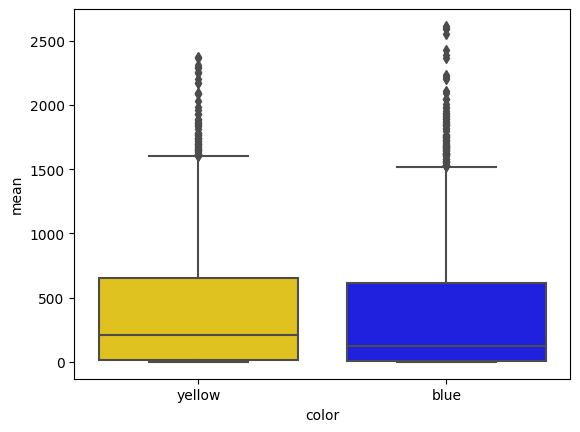

In [61]:
fig

In [8]:
print(confusion_matrix(results["color"], results["pred"]) / len(results))
print(f"accuracy = {acc}")

accuracy = 0.5365


## Shuffling

In [15]:
predictions = predict_images(
    sampled_images,
    neuron_data,
    shuffled_connections,
    all_coords,
    all_neurons,
    num_passes,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

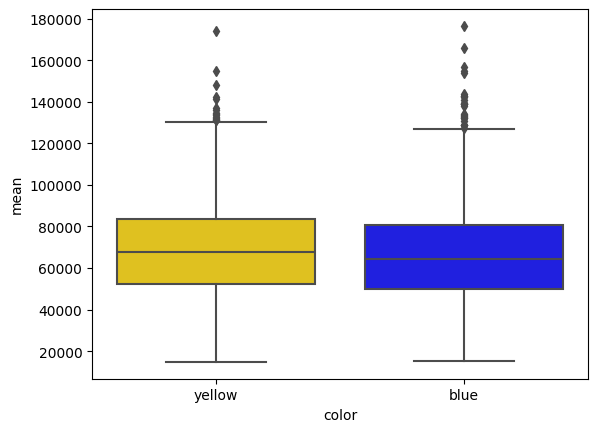

In [21]:
results = process_points_results(predictions)
fig, acc = log_results(results, "points", shuffled=True)
fig

In [24]:
print(f"accuracy = {acc}")

[[0.262 0.238]
 [0.238 0.262]]
accuracy = 0.524


# With shapes

In [9]:
base_dir = "images/black_blue_80_110_jitter/train/two_shapes"
sub_dirs = ["circle", "triangle"]

sampled_images = sample_images(base_dir, sub_dirs, pairs_num)
predictions = predict_images(
    sampled_images, neuron_data, connections, all_coords, all_neurons, num_passes
)

In [32]:
results = process_shapes_results(predictions, sampled_images)
fig, acc = log_results(results, "shapes")

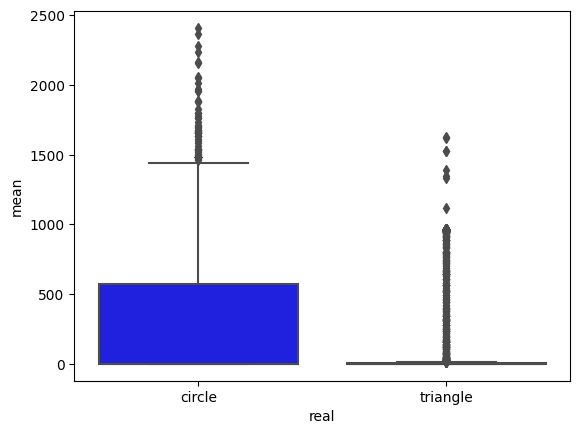

In [63]:
fig

In [54]:
print(f"accuracy = {acc}")

[[0.27725 0.22275]
 [0.35625 0.14375]]
accuracy = 0.579


# Reshuffle de pesos

In [64]:
predictions = predict_images(
    sampled_images, neuron_data, shuffled_connections, all_coords, all_neurons, num_passes
)

In [65]:
results = process_shapes_results(predictions, sampled_images)
fig, acc = log_results(results, "shapes", shuffled=True)
fig

In [67]:
print(f"accuracy = {acc}")

[[0.10775 0.39225]
 [0.39225 0.10775]]
accuracy = 0.7845


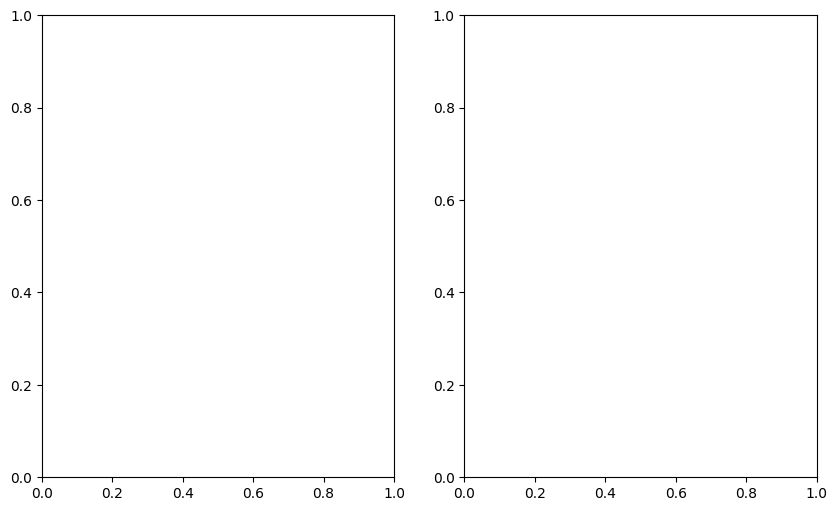

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

In [6]:
"_hola".replace("_", " ")

' hola'